<a href="https://colab.research.google.com/github/igorleonel/DataScience/blob/main/Analisando_as_olimpiadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Olimpíadas: Realizando Testes de Hipóteses e Regressão Linear.

Acesse a análise completa clicando [aqui](https://quickest-egg-336.notion.site/Olimp-adas-Realizando-Testes-de-Hip-teses-e-Regress-o-Linear-9daa44ae84ef4b1cae811f8a7d65a3e1).

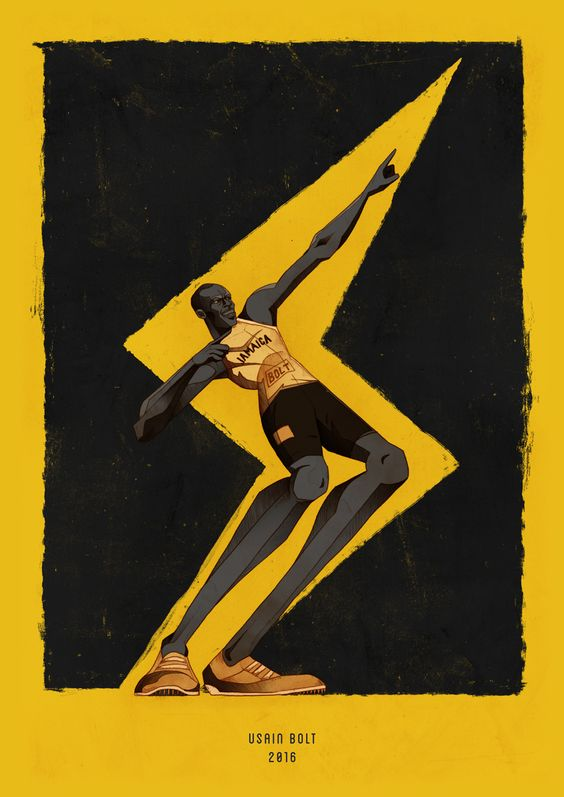

# Data Analyst

Os dados foram retirados do [Kaggle](https://www.kaggle.com/), e você pode encontrá-los [aqui](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results?select=athlete_events.csv). O objetivo deste artigo é examinar os dados de atletas olímpicos e edições desde sua edição da Era Moderna (1896) até a edição do Rio de Janeiro (2016), usando testes de hipóteses e regressão linear nas principais modalidades olímpicas.

In [8]:
# Importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics as st
import math
from sklearn import linear_model
from matplotlib.gridspec import GridSpec
from scipy import stats as ss

In [9]:
# Importando os dados e visualizando
df = pd.read_csv('athlete_events.csv')
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [10]:
# Primeira edição da Era Moderna e a última
print(f"Primeira edição: {df.Year.min()} na cidade de {df[df.Year == 1896]['City'].unique()[0]}")
print(f"Última edição: {df.Year.max()} na cidade do {df[df.Year == 2016]['City'].unique()[0]}")

Primeira edição: 1896 na cidade de Athina
Última edição: 2016 na cidade do Rio de Janeiro


In [11]:
# Visualizando os dados faltantes nas variáveis
df.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

# Descrição dos dados

A base de dados extraída no Kaggle, possui `271116` entradas e `15` variáveis. Cada linha corresponde a um atleta individual competindo em um evento olímpico individual (eventos-atleta). As colunas são:

In [12]:
# Quantidade de dados e variáveis
print(f'A base de dados possui {len(df)} e {len(df.columns)} variáveis')

A base de dados possui 271116 e 15 variáveis


## As colunas são:

1. **`ID`** - Identificador para cada atleta
2. **`Name`** - Nome do atleta
3. **`Sex`** - Sexo
4. **`Age`** - Idade
5. **`Height`** - Altura em centímetro
6. **`Weight`** - Peso em quilograma
7. **`Team`** - Nome do time
8. **`NOC`** - Código de 3 letras do Comitê Olímpico Nacional
9. **`Games`** - Ano e temporada
10. **`Year`** - Ano
11. **`Season`** - Verão ou Inverno
12. **`City`** - Cidade sede
13. **`Sport`** - Sport
14. **`Event`** - Evento
15. **`Medal`** - Ouro, Prata, Bronze, ou NA

# A pequena análise exploratória

Segundo a [Wikipedia](https://pt.wikipedia.org/wiki/Atletas_mais_medalhados_nos_Jogos_Ol%C3%ADmpicos), o superestimado **Michael Phelps** ganhou o maior número de medalhas de todas as edições olímpicas, totalizando `28` medalhas no total, `23` ouros, `3` pratas e `2` bronzes. Com essa informação básica, podemos iniciar com uma simples distribuição de frequência e verificar quantas vezes o Michael Phelps subiu ao pódio **segundo o nosso dataset:**

In [13]:
# Visualizando as quantidades de medalhas dos atletas
df[['Name', 'Medal']].groupby('Name').count().sort_values(by='Medal', ascending=False)[:5]

,Medal
Name,
"Michael Fred Phelps, II",28
Larysa Semenivna Latynina (Diriy-),18
Nikolay Yefimovich Andrianov,15
Takashi Ono,13
Borys Anfiyanovych Shakhlin,13


Como a maioria das pessoas prefere jogos de verão a jogos de inverno, **excluiremos os jogos de inverno**. De acordo com nosso *dataset*, ao todo temos `116.776` **atletas registrados**, `230` países participantes e `29` edições ao todo (**1916**, **1940** e **1944** foram **canceladas devido a guerras**, e em 1906 uma edição extraordinária dos Jogos Olímpicos foi realizada na cidade de Atenas para comemorar o 10º aniversário do início dos Jogos em 1896). Nos jogos de **1906**, competiram `841` atletas, sendo `835` do sexo masculino e apenas `6` do sexo feminino, com `21` nações participantes e `13` modalidades disputadas. A França foi a vencedora geral, com `45` medalhas.

In [14]:
# Excluindo os jogos de inverno
df = df[df['Season'] == 'Summer']

In [15]:
# Visualizando a quantidade atletas
print(f'Temos ao todo {len(df.ID.drop_duplicates())} atletas registrados, '
# Visualizando a quantidade de países participantes
f'{len(df.NOC.drop_duplicates())} países participantes '
# Visualizando a quantidade de edições
f"e {len(df[df.Season == 'Summer']['City'].drop_duplicates())} edições ao todo.")

Temos ao todo 116776 atletas registrados, 230 países participantes e 23 edições ao todo.


In [16]:
# Os jogos de 1906
# Distribuição dos sexos
qtde_fem = len(df.query("Year == 1906 and Sex == 'F'")['Name'].drop_duplicates())
qtde_mas = len(df.query("Year == 1906 and Sex == 'M'")['Name'].drop_duplicates())
# Quantidade de atletas
print(f"Nos jogos de 1906, competiram {len(df.query('Year == 1906')['Name'].drop_duplicates())} atletas, sendo "
f"{qtde_mas} do sexo masculino e apenas {qtde_fem} do sexo feminino, "
# Quantidade de nações participantes
f"com {len(df.query('Year == 1906')['NOC'].drop_duplicates())} nações participantes e "
f"{len(df.query('Year == 1906')['Sport'].drop_duplicates())} modalidades disputadas.")

Nos jogos de 1906, competiram 841 atletas, sendo 835 do sexo masculino e apenas 6 do sexo feminino, com 21 nações participantes e 13 modalidades disputadas.


# Estatística descritiva: uma breve introdução e a inserção dos atletas ao longo do tempo
Gráficos 


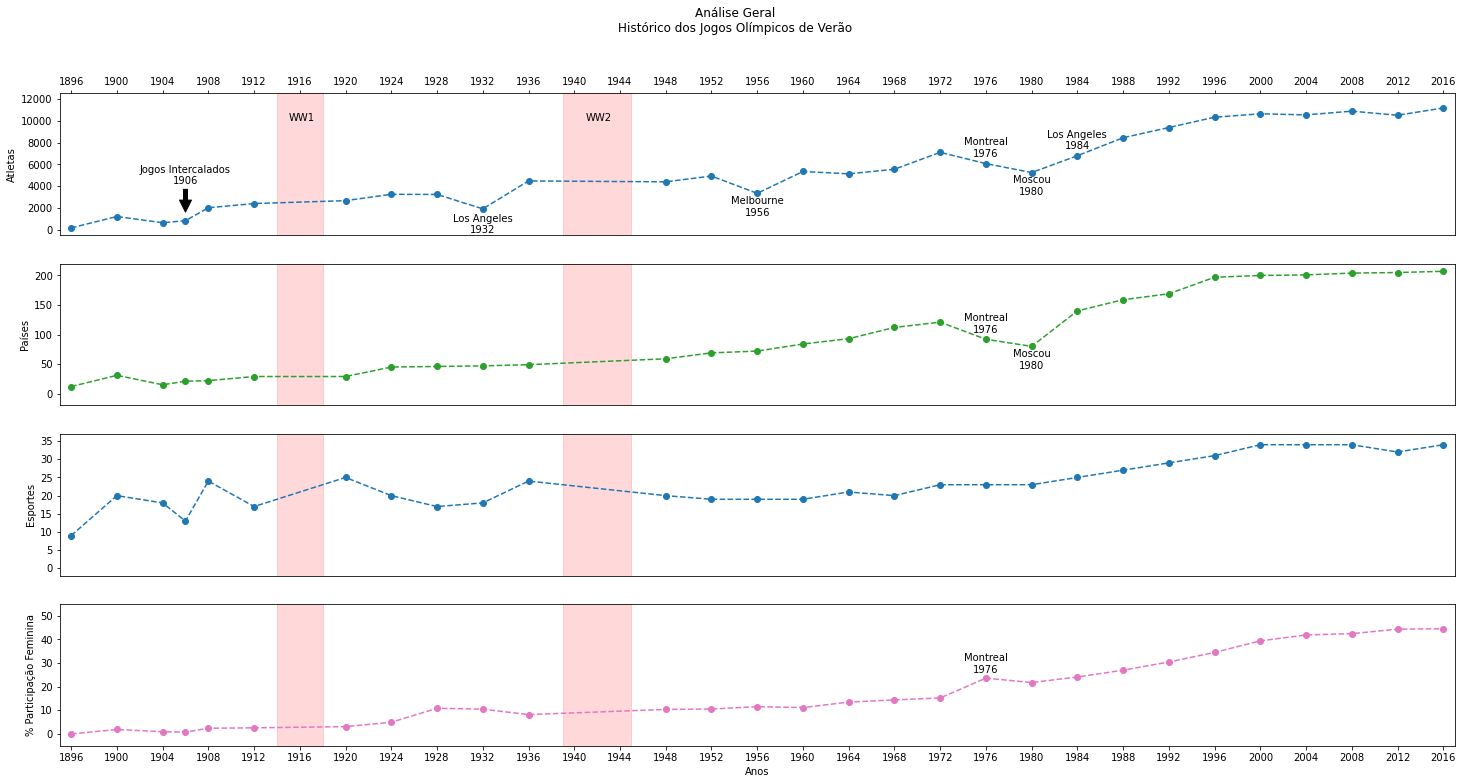

In [17]:
fig, (ax,ax2,ax3,ax4) = plt.subplots(4, figsize=(25,12), sharex=True)
# Atletas
ax.plot(df[['Name','Year']].
        drop_duplicates(
            subset=['Name','Year']).
        groupby('Year').
        count(),
        linestyle='--',
        marker='o')

ax.set_ylabel('Atletas')
ax.set_xlim([1895, 2017])
ax.set_yticks(np.arange(0,12001,2000))
ax.set_ylim([-500,12500])
ax.axvspan(1914, 1918, color='red', alpha=0.15)
ax.axvspan(1939, 1945, color='red', alpha=0.15)
ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False,labeltop=True)
ax.annotate("WW1",xy=(1915,10000), xycoords='data',)
ax.annotate("WW2",xy=(1941,10000), xycoords='data',)
ax.annotate('Jogos Intercalados\n1906', xy=(1906, 1500),  xycoords='data',
            xytext=(1906, 6000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top',
            )
ax.annotate("Los Angeles\n1932",xy=(1932,1500), xycoords='data',horizontalalignment='center',verticalalignment='top')
ax.annotate("Melbourne\n1956",xy=(1956,3100), xycoords='data',horizontalalignment='center',verticalalignment='top')
ax.annotate("Montreal\n1976",xy=(1976,6500), xycoords='data',horizontalalignment='center',verticalalignment='bottom')
ax.annotate("Moscou\n1980",xy=(1980,5000), xycoords='data',horizontalalignment='center',verticalalignment='top')
ax.annotate("Los Angeles\n1984",xy=(1984,7200), xycoords='data',horizontalalignment='center',verticalalignment='bottom');

#diferentes paises
ax2.plot(df[['NOC', 'Year']].drop_duplicates(subset=['NOC', 'Year']).groupby('Year').count(),
        linestyle='--', marker='o', color='tab:green')

ax2.set_ylabel('Países')
ax2.set_xlim([1895, 2017])
ax2.set_yticks(np.arange(0,201,50))
ax2.set_ylim([-20,220])
ax2.axvspan(1914, 1918, color='red', alpha=0.15)
ax2.axvspan(1939, 1945, color='red', alpha=0.15)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.annotate("Montreal\n1976",xy=(1976,100), xycoords='data',horizontalalignment='center',verticalalignment='bottom')
ax2.annotate("Moscou\n1980",xy=(1980,75), xycoords='data',horizontalalignment='center',verticalalignment='top');

#diferentes eventos
ax3.plot(df[['Sport','Year']].
         drop_duplicates(
             subset=['Sport','Year']).
         groupby('Year').
         count(),
         linestyle='--',
         marker='o',
         color='tab:blue')

ax3.set_ylabel('Esportes')
ax3.set_xlim([1895, 2017])
ax3.set_yticks(np.arange(0,40,5))
ax3.set_ylim([-2,37])
ax3.axvspan(1914, 1918, color='red', alpha=0.15)
ax3.axvspan(1939, 1945, color='red', alpha=0.15)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Participacao feminina nos jogos olímpicos
# gráfico de proporção de mulheres para homens na participação dos jogos olímpicos
df_men_women = (df[(df['Sex'] == 'F')][['Name','Year']].
                drop_duplicates(subset='Name').
                groupby('Year').
                count().
                rename(
                    columns={'Name':"Mulheres"})).merge(
                    (df[(df['Sex'] == 'M')][['Name','Year']].
                    drop_duplicates(subset='Name').
                    groupby('Year').
                    count().
                    rename(
                        columns={'Name':"Homens"})),
                    how='outer',
                    left_index=True,
                    right_index=True)
df_men_women = df_men_women.fillna(0)
df_men_women['Total'] = df_men_women['Mulheres']+df_men_women['Homens']
df_men_women['Mulheres'] = (df_men_women['Mulheres'] / df_men_women['Total']) * 100
df_men_women['Homens'] = (df_men_women['Homens'] / df_men_women['Total']) * 100
ax4.plot(df_men_women['Mulheres'], linestyle='--', marker='o',color='tab:pink')
ax4.set_ylabel('% Participação Feminina')
ax4.set_xlim([1895, 2017])
ax4.set_yticks(np.arange(0,51,10))
ax4.set_ylim([-5,55])
ax4.axvspan(1914, 1918, color='red', alpha=0.15)
ax4.axvspan(1939, 1945, color='red', alpha=0.15)
ax4.set_xlabel('Anos')
ax4.annotate("Montreal\n1976",xy=(1976,25), xycoords='data',horizontalalignment='center',verticalalignment='bottom')
fig.suptitle('Análise Geral\nHistórico dos Jogos Olímpicos de Verão')

plt.xticks(np.arange(1896,2017,4))
plt.show()

# O desempenho dos países nas olimpíadas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


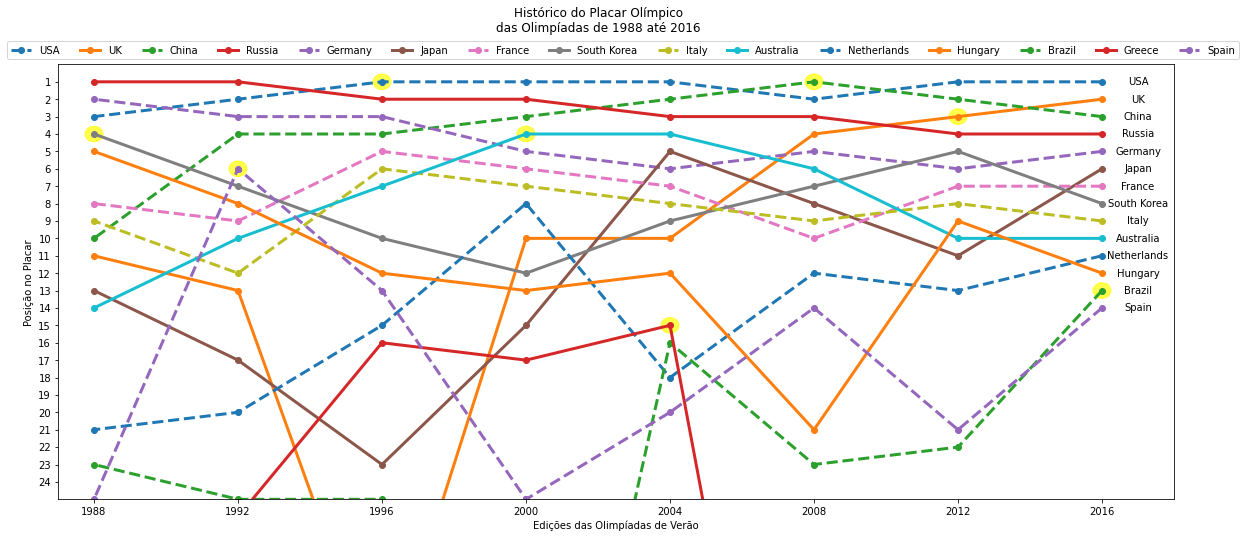

In [18]:
# Retirando os registros dos jogos intercalados dos dados
df = df[df['Year'] != 1906]

# contabilizar as medalhas de ouro, prata e bronze de cada atleta e depois agrupar por modalidade, e contar
# as medalhas das modalidades por país
def cont_medals (df, medal):
    df[medal] = df['Medal'].apply(lambda x: True if (x == medal) else False)
    
cont_medals(df, 'Gold')
cont_medals(df, 'Silver')
cont_medals(df, 'Bronze')

noc_regions = pd.read_csv('noc_regions.csv')
df = df.merge(noc_regions, how='inner', left_on='NOC', right_on='NOC')

df_quadro_medalhas = df.groupby(['region','Year','Event']).sum()
df_quadro_medalhas['Gold'] = df_quadro_medalhas['Gold'].apply(lambda x: 1 if (x >= 1) else 0)
df_quadro_medalhas['Silver'] = df_quadro_medalhas['Silver'].apply(lambda x: 1 if (x >= 1) else 0)
df_quadro_medalhas['Bronze'] = df_quadro_medalhas['Bronze'].apply(lambda x: 1 if (x >= 1) else 0)

df_quadro_medalhas = df_quadro_medalhas.reset_index()
df_quadro_medalhas = df_quadro_medalhas.groupby(['region', 'Year']).sum()
df_quadro_medalhas = df_quadro_medalhas.reset_index()

years = [x for x in range(1988, 2017, 4)]
all_olympics = []
for x in years:
    olympic_result = (df_quadro_medalhas[df_quadro_medalhas['Year'] == x][['Gold','Silver','Bronze','Year','region']].
                      groupby(['Year','region']).
                      sum().
                      sort_values(by=['Gold','Silver','Bronze'],
                                  ascending=False))
    
    all_olympics.insert(0,olympic_result)

# Criando posições
for game in all_olympics:
    i = 1
    game['Position'] = 0
    for index, row in game.iterrows():
        row['Position'] = i
        i += 1

# agora que eu ja tenho o resultado por olimpiada, pra conseguir deixar do jeito que eu quero no grafico, 
# eu tenho que unir todos os resultados da lista e depois dividir em elementos por país
all_olympics_concat = pd.concat(all_olympics).reset_index()

def country_group(df):
    paises = all_olympics_concat['region'].unique()
    country_df = []
    for pais in paises:
        line = all_olympics_concat[all_olympics_concat['region'] == pais].sort_values(by='Year',ascending=False).set_index('Year')
        country_df.insert(0,line)
    return country_df

from matplotlib.patches import Ellipse

# agora eu quero fazer um grafico que mostra a mudança de posicao do primeiro lugar de cada edicao dos jogos olimpicos
# cada país será uma linha (vou começar pegando só os 10 primeiros colocados)
fig, ax = plt.subplots(figsize=(20,8), sharex=True)
qtde_paises = 14
i = 1

# vou pegar a grecia separado pois ela é a unica que nao vai aparecer na lista dos melhores colocados
# do Rio e que sediou olimpiadas recentemente
for country in country_group(all_olympics_concat):
    if country['region'].iloc[0] == 'Greece':
        greece = country

best_countries = country_group(all_olympics_concat)[::-1][0:qtde_paises]
best_countries.insert(-1,greece)

for country in best_countries:
    if (i%2 == 0):
        ax.plot(country['Position'], marker='o',label=country['region'].iloc[0],linewidth=3)
    else:
        ax.plot(country['Position'], marker='o',linestyle='--',label=country['region'].iloc[0],linewidth=3)
    ax.annotate(country['region'].iloc[0],xy=(2017,country['Position'].loc[2016]), xycoords='data',horizontalalignment='center',verticalalignment='center')
    i+=1
    ax.legend(bbox_to_anchor=(-0.05, 1),loc='lower left',ncol=qtde_paises+1)
ax.invert_yaxis()
ax.set_ylabel('Posição no Placar')
ax.set_xlabel('Edições das Olimpíadas de Verão')
plt.xticks(np.arange(1988,2017,4))
plt.yticks(np.arange(1,25,1))
ax.set_xlim([1987, 2018])
ax.set_ylim([25, 0])
fig.suptitle('Histórico do Placar Olímpico\ndas Olimpíadas de 1988 até 2016')

# colocando elipse nas posicoes dos países que sediaram as olimpiadas
color = 'yellow'
# Seul
circle = Ellipse((1988,4), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Barcelona
circle = Ellipse((1992,6), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Atlanta
circle = Ellipse((1996,1), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Sidney
circle = Ellipse((2000,4), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Athenas
circle = Ellipse((2004,15), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Pequim
circle = Ellipse((2008,1), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Londres
circle = Ellipse((2012,3), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)
# Rio
circle = Ellipse((2016,13), 0.5,0.9,alpha=0.7,color=color)
ax.add_artist(circle)


plt.show()


# Os velocistas são mais pesados e maiores do que os maratonistas?

Vamos agora avaliar e testar a hipótese de Maratonistas x Velocistas - velocistas são aqueles que competem 100m rasos. Vamos testar a teoria de que atletas que correm 100m rasos são mais pesados e maiores do que os maratonistas.

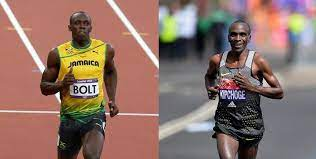

## Mas antes de iniciarmos o teste de hipótese, é importante verificarmos os valores discrepantes (outliers) e fazer uma breve observação

### Antes vamos criar uma tabela apenas com velocistas e maratonistas

In [20]:
# 1º para facilitar a manipulação dos dados, vamos substituir algumas coisas 
df = df.replace(["Athletics Men's 100 metres", "Athletics Men's Marathon"], ["Athletics Mens 100 metres", "Athletics Mens Marathon"])

In [21]:
# Apenas velocistas
velocistas = df[(df['Event'] == 'Athletics Mens 100 metres') & (df['Height'] >= 1) & (df['Weight'] >= 1)]

In [22]:
# Apenas maratonistas
maratonistas = df[(df['Event'] == 'Athletics Mens Marathon') & (df['Height'] >= 1) & (df['Weight'] >= 1)]

In [23]:
# Juntando os dois
vm = pd.concat([velocistas, maratonistas])

In [24]:
# Em seguida, vamos verificar a evolução das médias ao longo do tempo e analisar qual está "acima da média"
vm.groupby('Year')[['Height', 'Weight']].mean()

,Height,Weight
Year,,
1896,177.375000,75.250000
1900,173.333333,65.333333
1904,171.555556,61.944444
1908,174.151515,66.272727
1912,174.561404,66.271930
1920,174.034483,67.137931
1924,171.717949,65.230769
1928,171.568627,62.901961
1932,171.828571,64.257143


A edição que mais me chamou atenção foi a de **1896**, com média de **1.77m** (muito acima das demais médias) o que significa que algum atleta está “puxando” a média para cima; resolvi então, verificar os outliers com a biblioteca **PyOD** - instanciei o objeto e fiz previsões acerca dos valores.

**Para saber mais sobre Outliers e como remove-los utilizando a biblioteca PyOD, acesse o meu post [aqui](https://medium.com/@igorleonelborba/como-identificar-outliers-com-a-biblioteca-pyod-cab0f3e1a1f5).**

In [27]:
# Importando a biblioteca PyOD
from pyod.models.knn import KNN

In [28]:
# Criando um DataFrame apenas com as alturas de 1896
p_edicao = pd.DataFrame({'Height':vm.query("Year == 1896")['Height']})
p_edicao

,Height
63947,171.0
72378,183.0
73449,176.0
78238,170.0
101244,179.0
102665,167.0
162582,188.0
63384,185.0


In [29]:
# Instanciando o objeto
detector = KNN()
detector.fit(p_edicao)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [30]:
# Detectando os valores outliers
previsoes = detector.labels_
previsoes

array([0, 0, 0, 0, 0, 0, 1, 0])

Com base no nosso modelo para detectar outliers, a altura do atleta `Launceston Elliot` foi considerada “alta” em relação aos demais atletas da edição de 1896 com 188.0m.

In [33]:
# Visualizando se a altura se mantém constante ao longo dos anos
df[df.Name == 'Launceston Elliot']

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Gold,Silver,Bronze,region,notes
162582,32330,Launceston Elliot,M,21.0,188.0,102.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Athletics,Athletics Mens 100 metres,NaN,False,False,False,UK,NaN
162583,32330,Launceston Elliot,M,21.0,188.0,102.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Weightlifting,"Weightlifting Men's Unlimited, One Hand",Gold,True,False,False,UK,NaN
162584,32330,Launceston Elliot,M,21.0,188.0,102.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Weightlifting,"Weightlifting Men's Unlimited, Two Hands",Silver,False,True,False,UK,NaN
162585,32330,Launceston Elliot,M,21.0,188.0,102.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Wrestling,"Wrestling Men's Unlimited Class, Greco-Roman",NaN,False,False,False,UK,NaN
162586,32330,Launceston Elliot,M,21.0,188.0,102.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Gymnastics,Gymnastics Men's Rope Climbing,NaN,False,False,False,UK,NaN
162587,32330,Launceston Elliot,M,25.0,188.0,102.0,Great Britain,GBR,1900 Summer,1900,Summer,Paris,Athletics,Athletics Men's Discus Throw,NaN,False,False,False,UK,NaN


Como podemos ver, não podemos excluí-los, pois sua altura manteve constante em outras edições, então, seria desnecessário excluir. O segundo valor “alto”, segue sendo do Dimitrios Deligiannis com 1.85m, esse, ao longo das edições, “caiu” e se manteve com 1.76m, considerando assim, um possível erro ao incluí-lo na base de dados. Assim sendo, vamos excluí-lo da nossa base de dados.

In [34]:
# Analisando o segundo valor mais alto da edição de 1896
df[df.Name == 'Dimitrios Deligiannis']

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Gold,Silver,Bronze,region,notes
63381,27317,Dimitrios Deligiannis,M,22.0,176.0,85.0,Greece,GRE,1984 Summer,1984,Summer,Los Angeles,Sailing,Sailing Mixed Three Person Keelboat,NaN,False,False,False,Greece,NaN
63382,27317,Dimitrios Deligiannis,M,26.0,176.0,85.0,Greece,GRE,1988 Summer,1988,Summer,Seoul,Sailing,Sailing Mixed Three Person Keelboat,NaN,False,False,False,Greece,NaN
63383,27317,Dimitrios Deligiannis,M,30.0,176.0,85.0,Greece,GRE,1992 Summer,1992,Summer,Barcelona,Sailing,Sailing Mixed Three Person Keelboat,NaN,False,False,False,Greece,NaN
63384,27318,Dimitrios Deligiannis,M,NaN,185.0,106.0,Greece,GRE,1896 Summer,1896,Summer,Athina,Athletics,Athletics Mens Marathon,NaN,False,False,False,Greece,NaN


In [35]:
# Excluindo Dimitrios Deligiannis
vm = vm[vm.Name != "Dimitrios Deligiannis"]

In [37]:
# Analisando quantos atletas tem na edição de 1896
len(vm[vm.Year == 1896])

7

Podemos observar outro problema na edição de 1896, pois este, possui apenas 7 atletas - número significativamente baixo -  e todos eles são consideravelmente próximo a média geral de outros atletas. Por fim, iremos analisar a edição de 1900 até 2016.

# Teste de Hipótese

In [42]:
# Vamos retirar todos os valores duplicados da base de dados
def get_df_event(df, event):
    return (df[df['Event'] == event].
           drop_duplicates(
               subset=['Name', 'Height', 'Weight', 'NOC']))

In [43]:
# Intervalo de confiança
def intervalo_confianca(df,teste,confianca):
    media = st.mean(df[teste])
    desvio_padrao = st.stdev(df[teste])
    erro_padrao = desvio_padrao / math.sqrt(len(df))
    area_meio = confianca
    zscore = ss.norm.ppf(area_meio)
    #print(media,desvio_padrao,erro_padrao,zscore)
    return (round(media - (erro_padrao*zscore),4),round(media+(erro_padrao*zscore),4))

In [47]:
# Tratamentos dos dados
teste_1 = 'Height'
teste_2 = 'Weight'
maratona = 'Athletics Mens Marathon'
cem_metros = 'Athletics Mens 100 metres'
df_maratonistas = get_df_event(df,maratona).dropna(subset=['Height', 'Weight'])
df_maratonistas = df_maratonistas[df_maratonistas['Year'] > 1896]
df_velocistas = get_df_event(df,cem_metros).dropna(subset=['Height', 'Weight'])
df_velocistas = df_velocistas[df_velocistas['Year'] > 1896]

In [48]:
# Confiança 
conf = 0.95

In [49]:
# Bootstrap
def bootstrap_mean(x, confianca,n=5000, size=None):
    if size is None:
        size = len(x)
    values = np.zeros(n)
    for i in range (n):
        sample = np.random.choice(x,size=size,replace=True)
        values[i] = sample.mean()
    return (round(np.percentile(values,(1-confianca)*100),4),round(np.percentile(values,(confianca)*100),4))

In [50]:
txt = "Com {confianca:.1f}% de confiança, o intervalo de confiança de {teste} em {tipo} é: {intervalo} / [Boostrap: {boot}]"

In [51]:
print("Resultados Teste 1: Altura")
print(txt.format(confianca = conf*100,teste = teste_1,tipo = cem_metros,intervalo = intervalo_confianca(df_velocistas,teste_1,conf),boot=bootstrap_mean(df_velocistas[teste_1],conf)))
print(txt.format(confianca = conf*100,teste = teste_1,tipo = maratona,intervalo = intervalo_confianca(df_maratonistas,teste_1,conf),boot=bootstrap_mean(df_maratonistas[teste_1],conf)))
print()
print("Resultados Teste 2: Peso")
print(txt.format(confianca = conf*100,teste = teste_2,tipo = cem_metros,intervalo = intervalo_confianca(df_velocistas,teste_2,conf),boot=bootstrap_mean(df_velocistas[teste_2],conf)))
print(txt.format(confianca = conf*100,teste = teste_2,tipo = maratona,intervalo = intervalo_confianca(df_maratonistas,teste_2,conf),boot=bootstrap_mean(df_maratonistas[teste_2],conf)))

Resultados Teste 1: Altura
Com 95.0% de confiança, o intervalo de confiança de Height em Athletics Mens 100 metres é: (176.3588, 177.0125) / [Boostrap: (176.3606, 177.0107)]
Com 95.0% de confiança, o intervalo de confiança de Height em Athletics Mens Marathon é: (171.7712, 172.4146) / [Boostrap: (171.7686, 172.4163)]

Resultados Teste 2: Peso
Com 95.0% de confiança, o intervalo de confiança de Weight em Athletics Mens 100 metres é: (71.3161, 72.0632) / [Boostrap: (71.3108, 72.0632)]
Com 95.0% de confiança, o intervalo de confiança de Weight em Athletics Mens Marathon é: (59.9956, 60.5464) / [Boostrap: (60.0036, 60.5513)]


## Podemos visualizar graficamente, através do método cumulativo e histograma de cada teste:

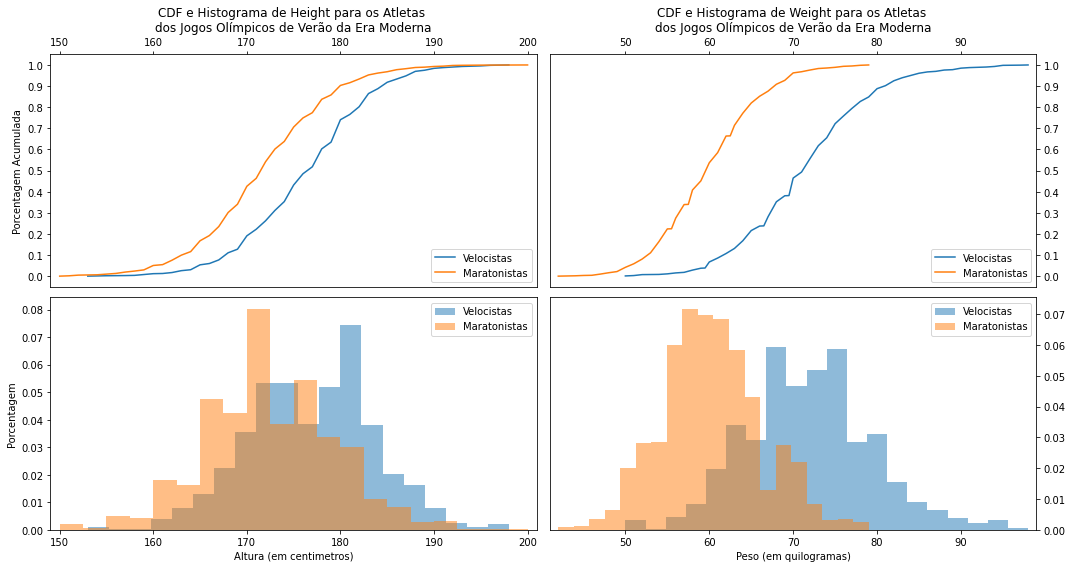

In [52]:
def tab_freq(df,teste):
    cdf = pd.DataFrame(df.groupby(by=teste).count()['Name'])
    cdf = cdf.rename(columns={"Name": "Qtde"})
    cdf['Qtde Acum'] = cdf['Qtde'].cumsum()
    cdf['Freq'] = cdf['Qtde'] / cdf['Qtde'].sum()
    cdf['Freq Acum'] = cdf['Freq'].cumsum()
    return cdf

def plot_cdf(teste,ax):
    maratonistas_freq = tab_freq(df_maratonistas,teste)
    velocistas_freq = tab_freq(df_velocistas,teste)
    ax.plot(velocistas_freq['Freq Acum'],label='Velocistas')
    ax.plot(maratonistas_freq['Freq Acum'],label='Maratonistas')
    ax.set_title("CDF e Histograma de {teste} para os Atletas \ndos Jogos Olímpicos de Verão da Era Moderna".format(teste=teste))
    
    ax.legend(loc='lower right')
    xlim = [min(maratonistas_freq.index[0],velocistas_freq.index[0])-1, max(maratonistas_freq.index[-1],velocistas_freq.index[-1])+1]
    ax.set_xlim(xlim)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='x', bottom=False, top=True, labeltop=True,labelbottom=False)
    return xlim
    
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,8))
xlim1 = plot_cdf(teste_1,ax1)
ax1.set_ylabel("Porcentagem Acumulada")
xlim2 = plot_cdf(teste_2,ax2)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False,labelright=True)
bins_ = 20
ax3.hist(df_velocistas[teste_1],alpha=0.5,bins=bins_,density=True,label='Velocistas')
ax3.hist(df_maratonistas[teste_1],alpha=0.5,bins=bins_,density=True,label='Maratonistas')
ax3.legend(loc='upper right')
ax3.set_ylabel("Porcentagem")
ax3.set_xlabel("Altura (em centimetros)")
ax3.set_xlim(xlim1)

ax4.hist(df_velocistas[teste_2],alpha=0.5,bins=bins_,density=True,label='Velocistas')
ax4.hist(df_maratonistas[teste_2],alpha=0.5,bins=bins_,density=True,label='Maratonistas')
ax4.legend(loc='upper right')
ax4.set_xlim(xlim2)
ax4.tick_params(axis='y', left=False, right=True, labelleft=False,labelright=True)
ax4.set_xlabel("Peso (em quilogramas)")
fig.savefig('cdf-hist-peso-altura.png')
plt.tight_layout()

# Existe correlação entre as duas variáveis? Podemos aplicar uma regressão linear simples.

Por último, podemos analisar a correlação entre a altura e o peso de uma mesma categoria; ou seja, vamos descobrir o impacto da Altura no Peso dos atletas.

**Modelo:**

In [53]:
def modelo_regressao_linear(df,x,y):
    regr = linear_model.LinearRegression()
    regr.fit(np.array(df[x]).reshape(1,-1).T,np.array(df[y]).reshape(1,-1).T)
    peso_simulado = regr.coef_[0][0] * df[x] + regr.intercept_[0]
    df.insert(5,y + ' simulado',peso_simulado)
    return (regr.coef_[0][0], regr.intercept_[0])

def imprime_modelo (coef_intercept):
    return ('f(x) = {coef:.2f}x + {intercept:.2f}'.format(coef=coef_intercept[0],intercept=coef_intercept[1]))

reg_velocistas = modelo_regressao_linear(df_velocistas,teste_1,teste_2)
reg_maratonistas = modelo_regressao_linear(df_maratonistas,teste_1,teste_2)

print("Modelo {modalidade}: {modelo}".format(modalidade=cem_metros,
                                             modelo=imprime_modelo(reg_velocistas)))
print("Modelo {modalidade}: {modelo}".format(modalidade=maratona,
                                             modelo=imprime_modelo(reg_maratonistas)))

Modelo Athletics Mens 100 metres: f(x) = 0.76x + -63.31
Modelo Athletics Mens Marathon: f(x) = 0.59x + -41.07


**Interpretação:**

- Para encontrar o Peso de um velocista, eu preciso pegar 76% de sua altura e diminuir 63.31
- Para encontrar o Peso de um maratonista, eu preciso pegar 59% de sua altura e diminuir 41.07

**Visualização do Modelo:**

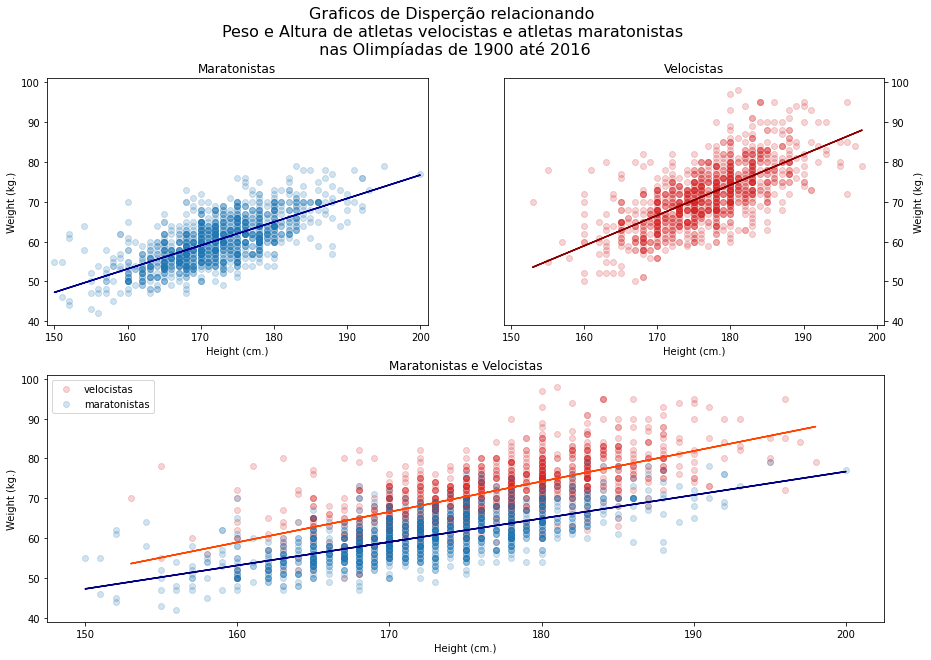

In [55]:
def min_max_teste (teste,is_max):
    df_maratonistas_velocistas = pd.concat([df_maratonistas,df_velocistas])
    if (is_max):
        return float(df_maratonistas_velocistas[df_maratonistas_velocistas[teste] == df_maratonistas_velocistas[teste].max()][teste])
    else:
        return float(df_maratonistas_velocistas[df_maratonistas_velocistas[teste] == df_maratonistas_velocistas[teste].min()][teste])

def ax_plot (ax,col_x,col_y,color_scatter,color_line,labelx,labely,df_aux,df,label):
    ax.scatter(df[col_x],df[col_y],alpha=0.2,label=label,color=color_scatter)
    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.set_yticks(np.arange(40,101,10))
    ax.set_ylim([39,101])
    ax.plot(df_aux,color=color_line)

def scatter_plot (col_x,col_y,modalidade,titulo,labelx,labely,dados_simulados):
    # criar um novo dataframe so com Height e Weight simulado pra conseguir plotar certinho junto da dispersão
    df_velocistas_aux = pd.DataFrame({col_x: df_velocistas[col_x], dados_simulados: df_velocistas[dados_simulados]}).set_index(col_x)
    df_maratonistas_aux = pd.DataFrame({col_x: df_maratonistas[col_x], dados_simulados: df_maratonistas[dados_simulados]}).set_index(col_x)
    
    fig=plt.figure(figsize=(15,10))
    gs=GridSpec(2,2) # 2 rows, 2 columns
    ax1=fig.add_subplot(gs[0,0]) # First row, first column
    ax1.set_title("Maratonistas")
    
    ax2=fig.add_subplot(gs[0,1]) # First row, second column
    ax2.set_title("Velocistas")
    ax2.tick_params(axis='y', left=False, right=True, labelleft=False,labelright=True)
    ax2.yaxis.set_label_position("right")
    ax2.set_xlim([min_max_teste(teste_1,False)-1,min_max_teste(teste_1,True)+1])
    ax1.set_xlim([min_max_teste(teste_1,False)-1,min_max_teste(teste_1,True)+1])
    ax2.set_ylim([min_max_teste(teste_2,False)-1,min_max_teste(teste_2,True)+1])
    ax1.set_ylim([min_max_teste(teste_2,False)-1,min_max_teste(teste_2,True)+1])
    ax=fig.add_subplot(gs[1,:]) # Second row, span all columns
    #fig, ((ax1,ax2),(ax)) = plt.subplots(nrows=2, ncols=2,figsize=(15,8))
    ax_plot(ax,col_x,col_y,'tab:red','orangered',labelx,labely,df_velocistas_aux,df_velocistas,'velocistas')
    ax_plot(ax,col_x,col_y,'tab:blue','navy',labelx,labely,df_maratonistas_aux,df_maratonistas,'maratonistas')
    
    ax_plot(ax1,col_x,col_y,'tab:blue','darkblue',labelx,labely,df_maratonistas_aux,df_maratonistas,'maratonistas')
    
    ax_plot(ax2,col_x,col_y,'tab:red','darkred',labelx,labely,df_velocistas_aux,df_velocistas,'velocistas')
    
    ax.legend(loc='upper left')
    ax.set_title("Maratonistas e Velocistas")
    fig.suptitle('Graficos de Disperção relacionando\nPeso e Altura de atletas velocistas e atletas maratonistas\n nas Olimpíadas de 1900 até 2016', fontsize=16)
    
scatter_plot(teste_1,
             teste_2,
             cem_metros,
             "Regressão Linear para\n" + cem_metros,teste_1+" (cm.)",teste_2 +" (kg.)",
             teste_2 + ' simulado')

O gráfico de dispersão prevê que atletas com maior estatura tenham maior peso; ou seja, à medida que a altura cresce, o peso também aumenta. A comparação das razões de crescimento peso-altura de atletas de várias modalidades é a parte mais interessante da análise. Como resultado, essa regressão linear conecta os dois testes de hipóteses realizados anteriormente: os maratonistas são menores e mais leves, mas os velocistas são maiores e mais pesados. As fotografias de Bolt e Kipchoge são representações precisas de suas respectivas modalidades.

Isso se dá ao fato que existem dois tipos de fibras musculares, que são classificadas em lentas e rápidas (1 e 2). Sendo assim, atletas e treinadores tendem a classificar as pessoas em um dos dois grupos e dizem que o tipo de músculo determina a capacidade atlética. Por isso, uns conseguem ter mais resistência (maratonistas) e outros mais velocidade (100m rasos). Isso é determinado geneticamente. 

**Outros links:**

- [Linkedin](https://www.linkedin.com/in/igorleonel/)

- [GitHub](https://github.com/igorleonel)

- [Medium](https://medium.com/@igorleonelborba)